In [1]:
import matplotlib.pyplot as plt

import MyEDFImports as m
import numpy as np
import wfdb.processing
import neurokit2
from functools import reduce
from operator import add
from dataclasses import dataclass
import pywt
import scaleogram as scg

In [2]:
edf_filenames = m.get_edf_filenames()
sfreq = 500
patients = {}
for name in edf_filenames:
    data = m.load_data_one_file(name)
    labels = m.load_labels_one_file(name)
    _, results = neurokit2.ecg_peaks(data.flatten(), sampling_rate=sfreq)
    all_peaks = results['ECG_R_Peaks']
    window_peaks = []
    cur_win = []
    cur_win_lim = 0
    for peak in all_peaks:
        if peak < cur_win_lim:
            cur_win.append(peak)
        else:
            window_peaks.append(cur_win)
            cur_win = []
            cur_win_lim += 20*500
    assert len(window_peaks) == len(data)
    patients[name] = list(zip(data,labels,window_peaks))

Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/CN223100.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
<RawEDF | CN223100.edf, 1 x 15611000 (31222.0 s), ~6 kB, data not loaded> with 1561 windows
loading from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers//CN223100.edf_stages.txt
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/CP229110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/MyEDFImports.py:42: RuntimeWarning: Channel names are not unique, found duplicates for: {'CHIN EMG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + "//" + name)


<RawEDF | CP229110.edf, 1 x 20078000 (40156.0 s), ~6 kB, data not loaded> with 2007 windows
importing inverted file: CP229110.edf
/home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/CP229110.edf
loading from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers//CP229110.edf_stages.txt
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/CX230050.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
<RawEDF | CX230050.edf, 1 x 17981000 (35962.0 s), ~6 kB, data not loaded> with 1798 windows
loading from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers//CX230050.edf_stages.txt
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/DG220020.edf...
EDF file detected
Setting channel info structure...
Creating raw.in

/home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/MyEDFImports.py:42: RuntimeWarning: Channel names are not unique, found duplicates for: {'CHIN EMG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + "//" + name)


<RawEDF | WD224010.edf, 1 x 17774000 (35548.0 s), ~6 kB, data not loaded> with 1777 windows
loading from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers//WD224010.edf_stages.txt


In [3]:
@dataclass
class window:
    data: np.ndarray
    label: int
    peaks: list
all_data_peaks = reduce(add,patients.values())
all_data_peaks = [window(w[0], w[1], w[2]) for w in all_data_peaks]

In [4]:
def get_all_from_stage(data_stream, stage):
    for datapoint in data_stream:
        label = datapoint.label
        if label == stage:
            yield datapoint

In [5]:
stages = m.stages_names.keys()
data_by_stage = dict()
for stage in stages:
    data_by_stage.update({stage:list(get_all_from_stage(all_data_peaks, stage))})
for k,v in data_by_stage.items():
    print(k, len(v))

0 3519
1 1127
2 8844
3 975
4 1310
5 3473


# investigating suspicious file LA216100.edf
sus_name = 'LA216100.edf'
sus_data = m.load_data_one_file(sus_name)
sus_labels = m.load_labels_one_file(sus_name)
### wfdb doesn't see in this file even one peak
all_peaks = wfdb.processing.xqrs_detect(sus_data.flatten(), fs=sfreq)
_, results = neurokit2.ecg_peaks(data.flatten(), sampling_rate=sfreq)
all_peaks_neuro = results['ECG_R_Peaks']

In [6]:
# avialable wavelets
pywt.wavelist('cmor')

['cmor']

/tmp/ipykernel_8253/2975737236.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


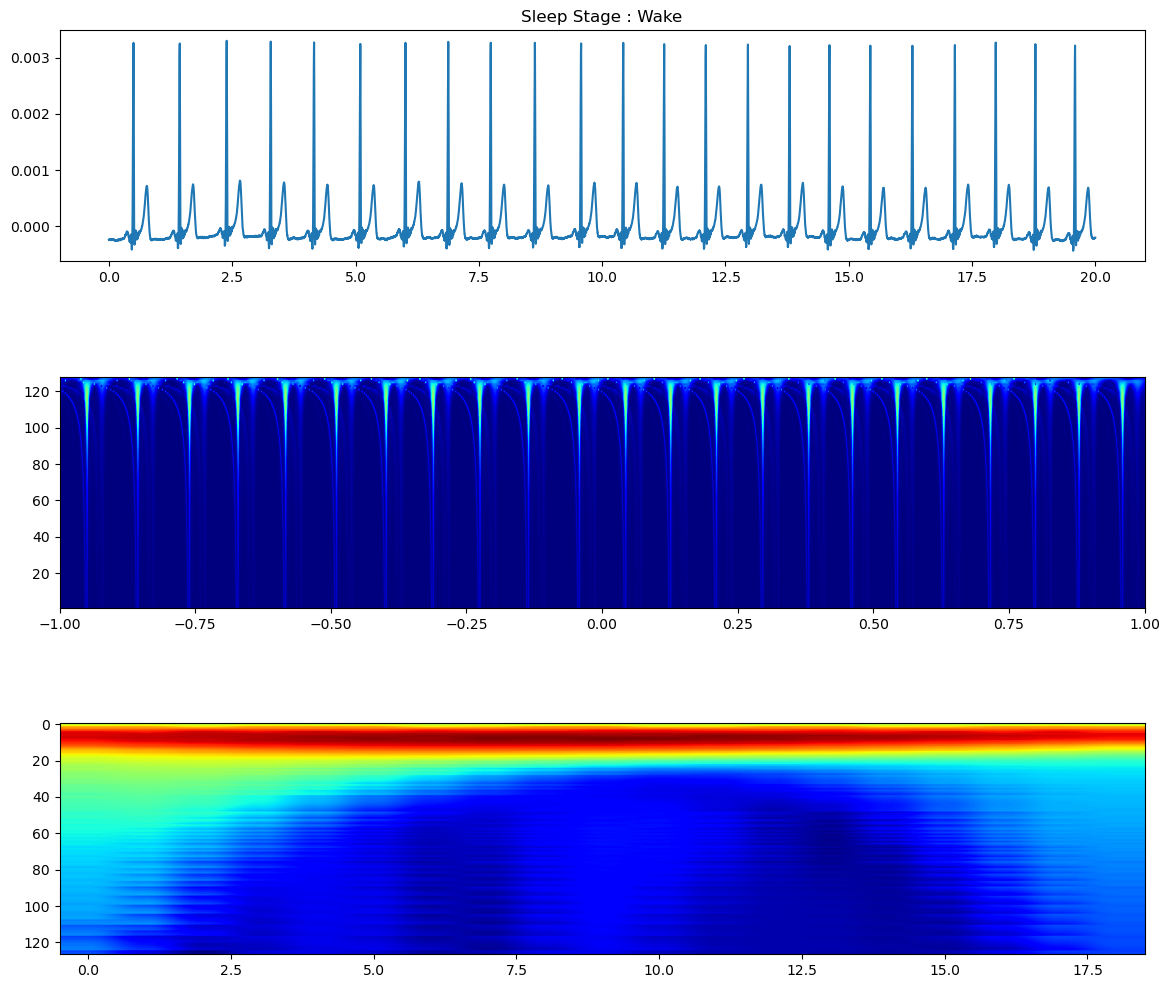

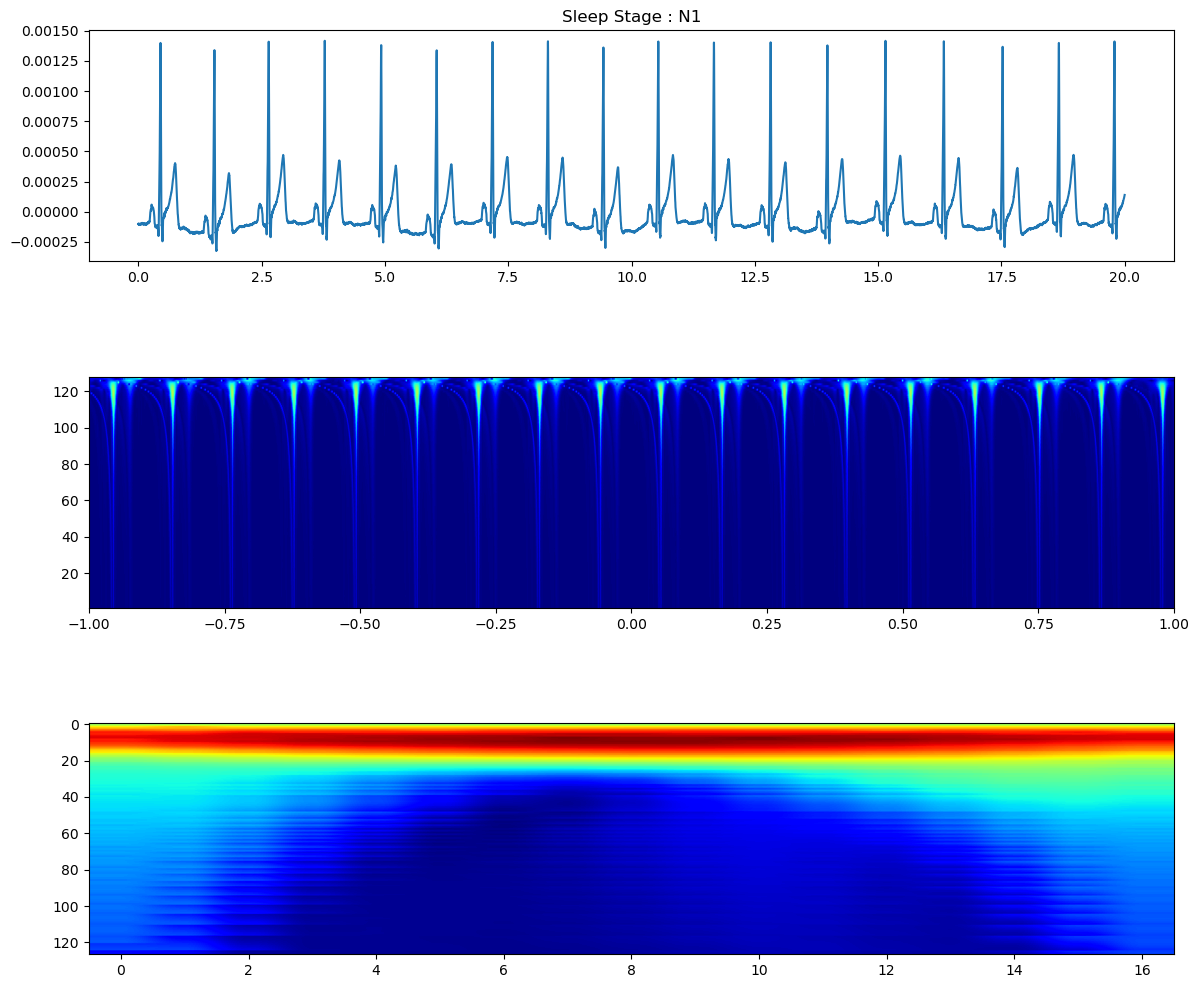

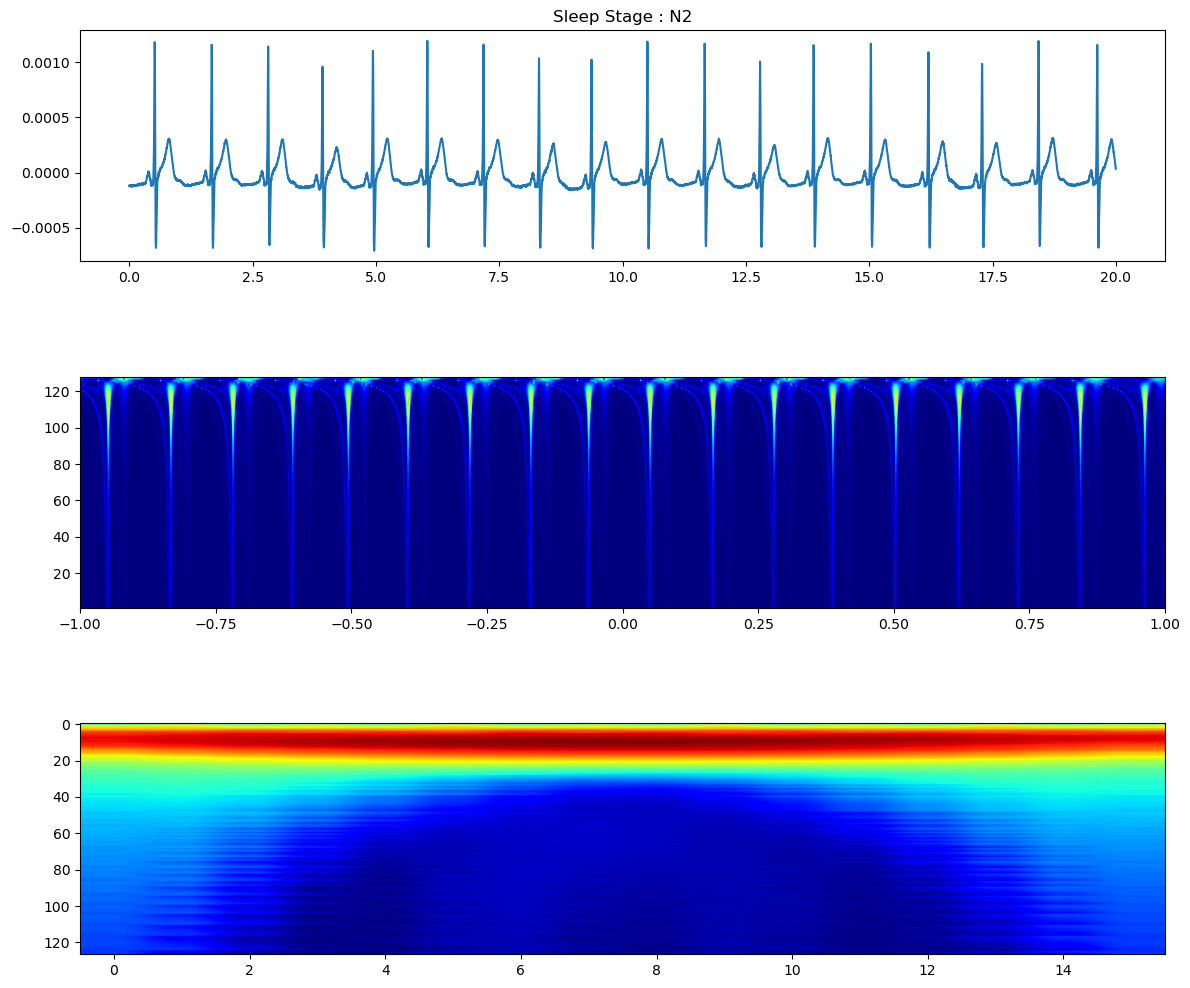

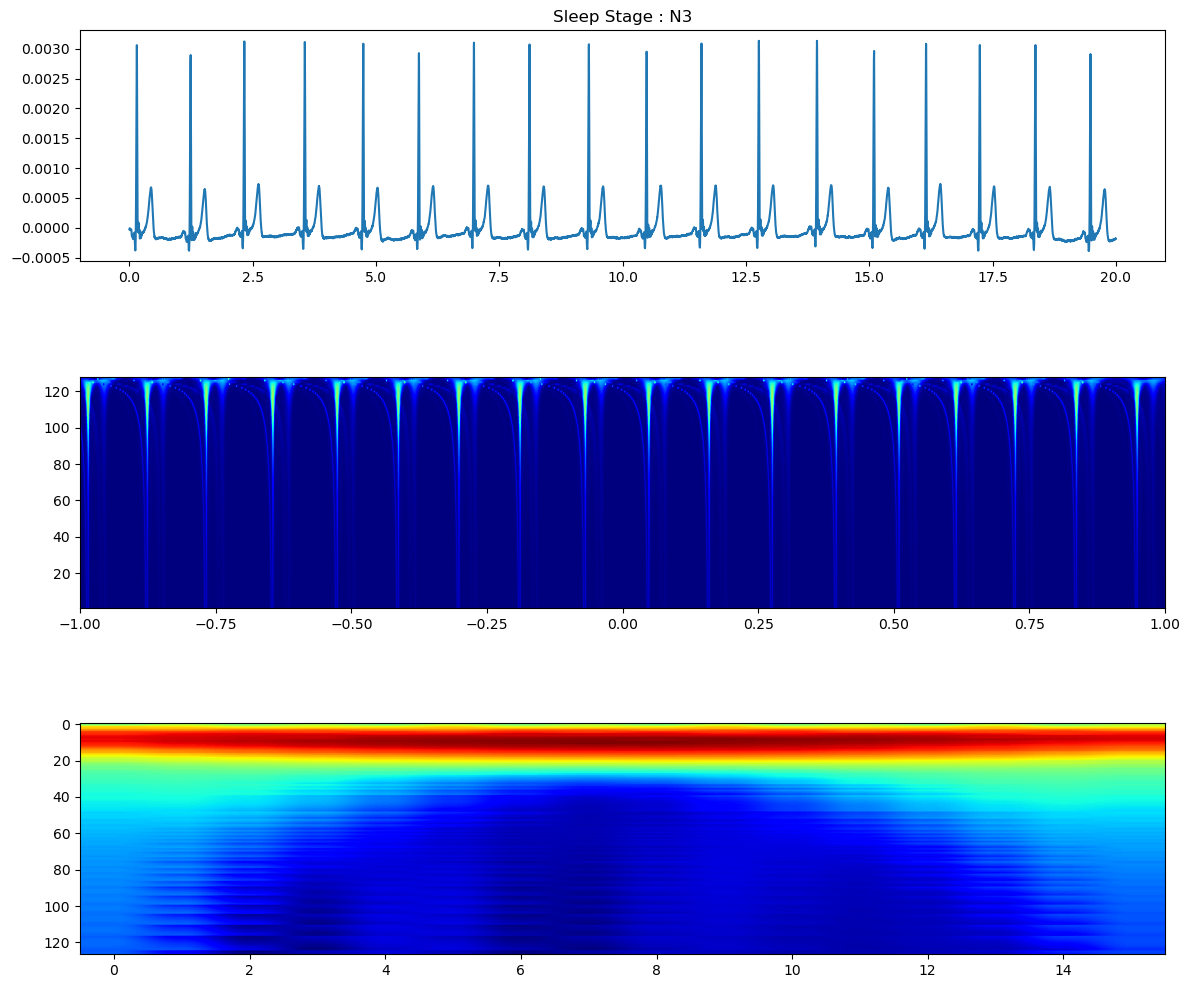

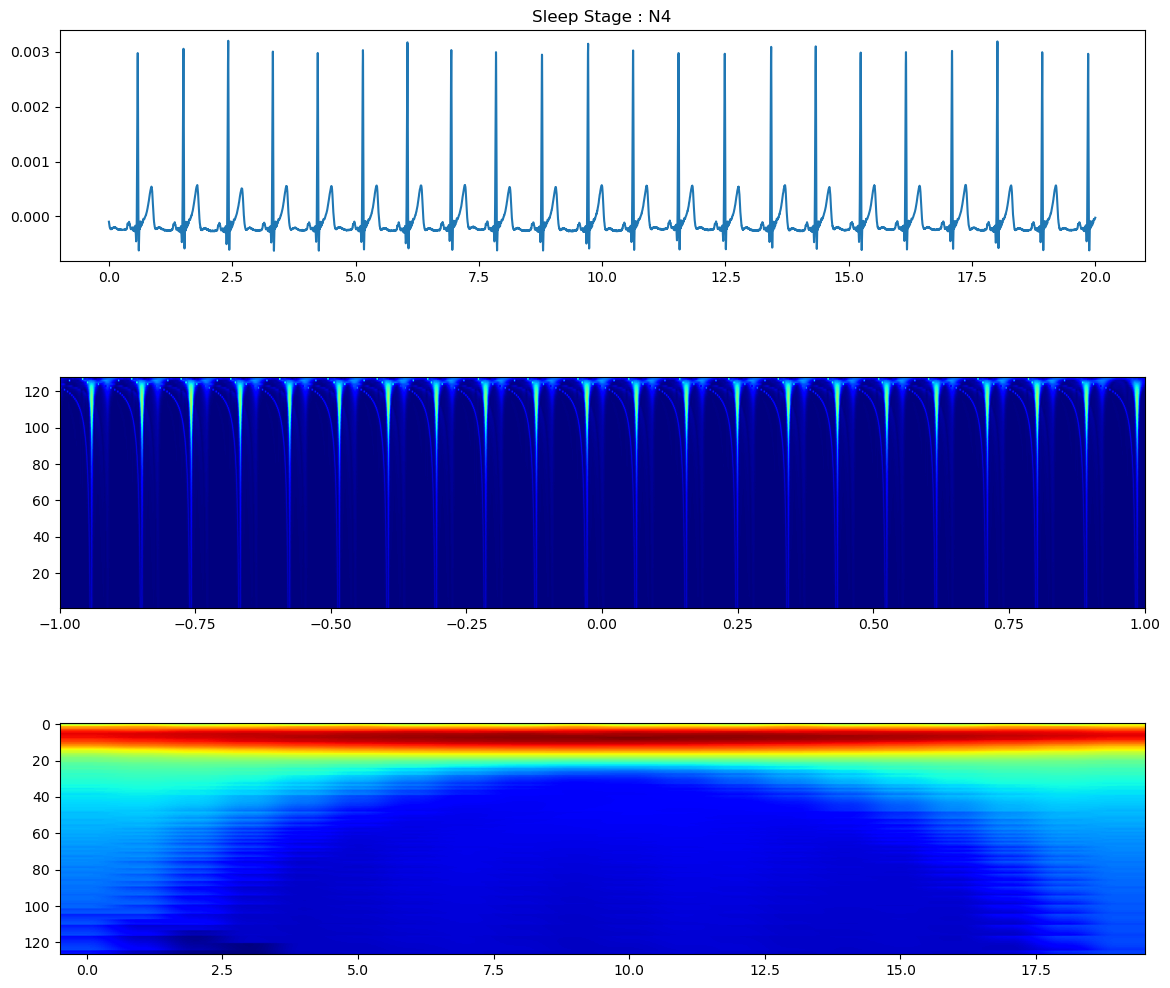

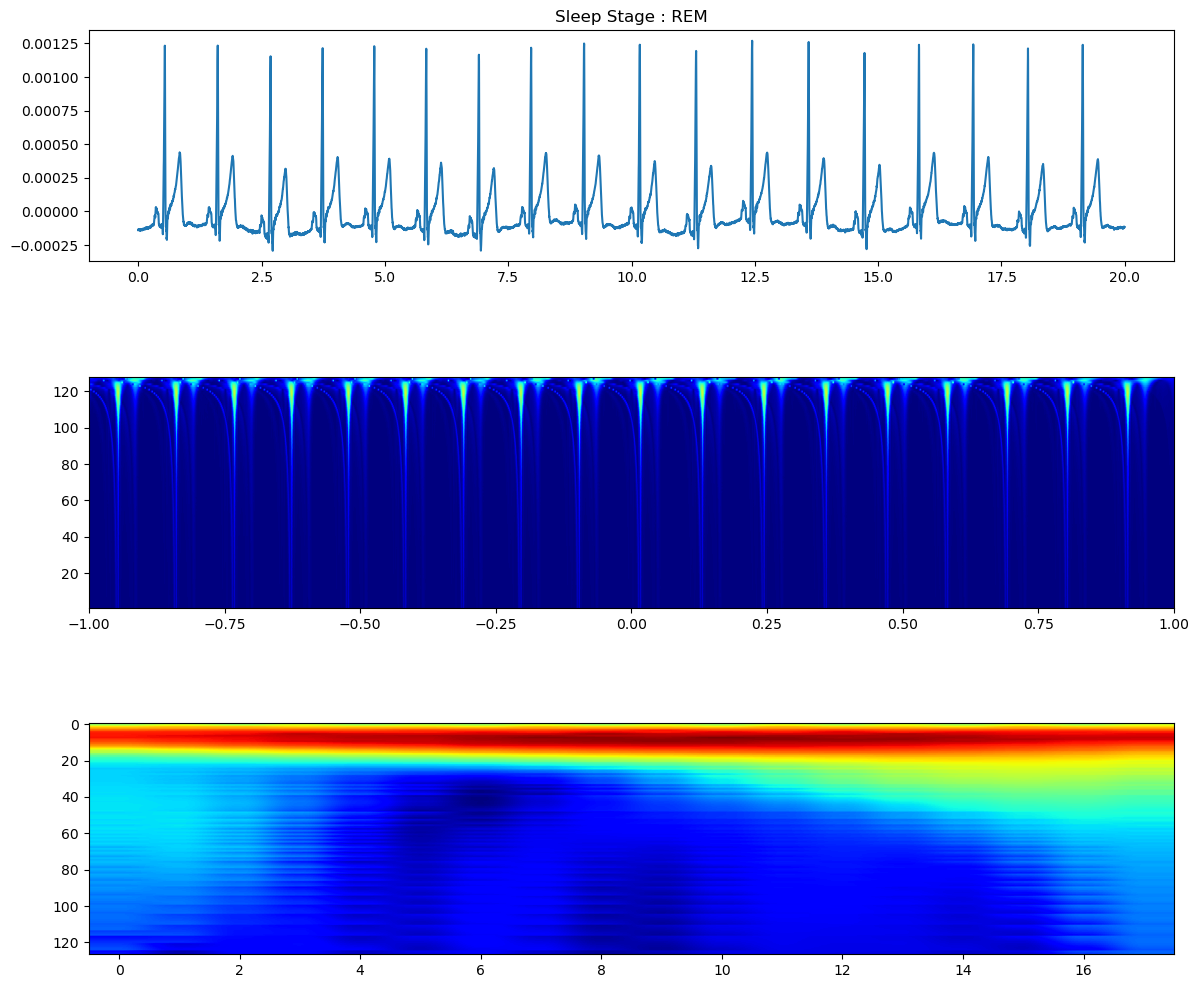

In [23]:
# choose 1 from given stages:
time = np.arange(10000)*0.002
for s in data_by_stage:
    # choose one at random
    windows = data_by_stage[s]
    ind = np.random.choice(len(windows),1 )[0]
    w = windows[ind].data
    l = windows[ind].label
    p = windows[ind].peaks
    #CWT data
    fa = np.arange(1,128)
    dt = 0.002
    wavelet = 'cmor'
    scales = pywt.central_frequency(wavelet)/(dt*fa)
    peaks_diff = np.diff(p)
    # cwt
    coef_w, freq_w = pywt.cwt(w, scales, wavelet)
    coef_p, freq_p = pywt.cwt(peaks_diff, scales, wavelet)
    coef_w = np.abs(coef_w)
    coef_p = np.abs(coef_p)
    # plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (14,12))
    fig.subplots_adjust(hspace=0.5)
    ax1.plot(time, w)
    ax1.set_title(f'Sleep Stage : {m.stages_names[s]}')
    ax2.imshow(coef_w, extent=[-1, 1, 1, 128], cmap='jet', aspect='auto',
               vmax=abs(coef_w).max(), )
    ax3.imshow(coef_p, cmap='jet', aspect='auto',
               vmax=abs(coef_p).max(), )
    # ax2 = scg.cws(time, w, scales=scales, wavelet=wavelet, cmap="jet", yaxis='frequency', spectrum='power', yscale='linear', ax=ax2)
    fig.show()


In [ ]:
time = np.arange(10000)*0.002